In [22]:
!pip install torch


In [23]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Define dataset paths based on extracted info
BASE_PATH = "/content/drive/My Drive/ColabNotebooks/Facial Feature Extraction Dataset"
TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, 'train', 'images')
TRAIN_LABELS_PATH = os.path.join(BASE_PATH, 'train', 'labels')
TEST_IMAGES_PATH = os.path.join(BASE_PATH, 'test', 'images')
TEST_LABELS_PATH = os.path.join(BASE_PATH, 'test', 'labels')

# Function to load YOLO annotation files and convert to Faster R-CNN format
def load_yolo_annotations(label_path, img_path):
    boxes = []
    labels = []

    # Get actual image dimensions
    img = cv2.imread(img_path)
    img_height, img_width = img.shape[:2]

    with open(label_path, "r") as file:
        for line in file.readlines():
            data = line.strip().split()
            class_id = int(data[0])
            x_center, y_center, width, height = map(float, data[1:])


            # Convert YOLO format (normalized) to pixel coordinates
            # Use actual image dimensions instead of assuming 640x640
            x_min = (x_center - width / 2) * img_width
            y_min = (y_center - height / 2) * img_height
            x_max = (x_center + width / 2) * img_width
            y_max = (y_center + height / 2) * img_height

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id + 1)  # Faster R-CNN labels start from 1

    return boxes, labels


# Use data augmentation
from torchvision import transforms

class FacialFeatureDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.image_paths = glob.glob(os.path.join(images_path, "*.jpg"))
        self.labels_path = labels_path
        self.class_names = ['eye', 'eyebrow', 'lip', 'mustache-beard', 'nose']
        self.num_classes = len(self.class_names) + 1  # Include background class
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label_file = os.path.join(self.labels_path, os.path.basename(img_path).replace(".jpg", ".txt"))
        boxes, labels = load_yolo_annotations(label_file, img_path)

        # Handle empty boxes
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        # Apply transforms
        if self.transform:
            height, width = img.shape[:2]
            # Convert boxes to normalized format for transforms
            normalized_boxes = boxes.clone()
            normalized_boxes[:, [0, 2]] /= width
            normalized_boxes[:, [1, 3]] /= height

            # Apply transform
            img = self.transform(img)

            # Convert back to pixel coordinates
            height, width = img.shape[1:3]  # New dimensions after transform
            boxes = normalized_boxes.clone()
            boxes[:, [0, 2]] *= width
            boxes[:, [1, 3]] *= height

        img = F.to_tensor(img)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return img, target



In [26]:
import glob
print(TRAIN_IMAGES_PATH)
print("Train Images:", len(glob.glob(f"{TRAIN_IMAGES_PATH}/*.jpg")))
print("Train Labels:", len(glob.glob(f"{TRAIN_LABELS_PATH}/*.txt")))

/content/drive/My Drive/ColabNotebooks/Facial Feature Extraction Dataset/train/images
Train Images: 457
Train Labels: 457


In [27]:
class_names = ['eye', 'eyebrow', 'lip', 'mustache-beard', 'nose']

def analyze_class_distribution(labels_path):
    class_counts = {i: 0 for i in range(len(class_names))}
    label_files = glob.glob(os.path.join(labels_path, "*.txt"))

    for label_file in label_files:
        with open(label_file, "r") as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1

    print("Class distribution in dataset:")
    for class_id, count in class_counts.items():
        print(f"{class_names[class_id]}: {count}")

analyze_class_distribution(TRAIN_LABELS_PATH)

Class distribution in dataset:
eye: 497
eyebrow: 515
lip: 466
mustache-beard: 521
nose: 461


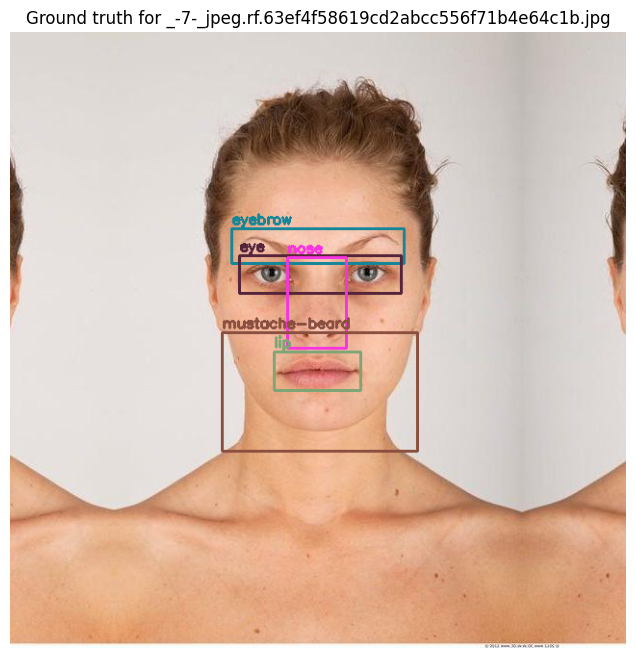

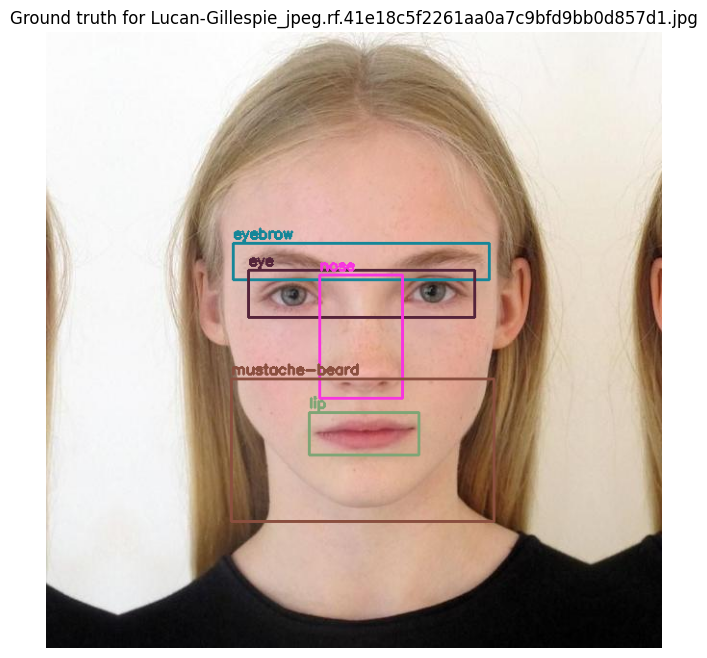

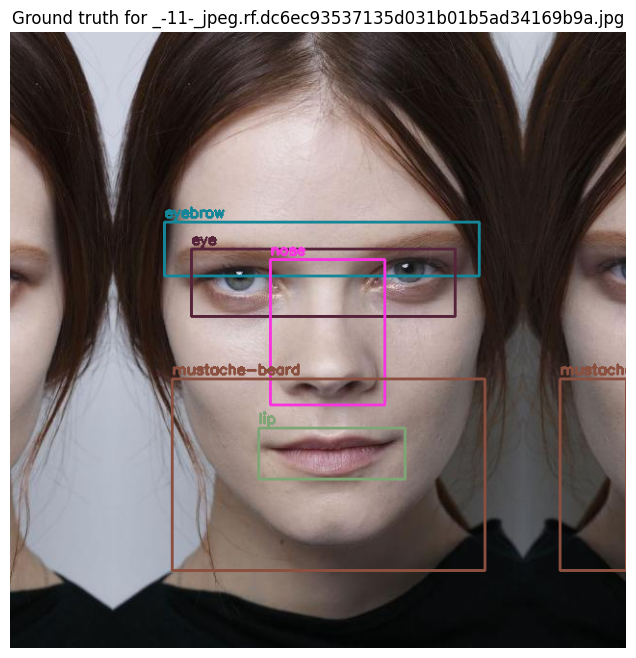

In [28]:
import random
class_colors = {name: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for name in class_names}

def visualize_ground_truth(images_path, labels_path, num_samples=3):
    image_files = glob.glob(os.path.join(images_path, "*.jpg"))
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    for img_path in sample_files:
        img = cv2.imread(img_path)
        label_file = os.path.join(labels_path, os.path.basename(img_path).replace(".jpg", ".txt"))

        boxes, labels = load_yolo_annotations(label_file, img_path)

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = map(int, box)
            class_name = class_names[label - 1]
            color = class_colors.get(class_name, (255, 255, 255))

            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, class_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Ground truth for {os.path.basename(img_path)}")
        plt.axis("off")
        plt.show()

visualize_ground_truth(TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)

In [29]:

# Define data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])


# Load dataset
# Use the transform in your datasetm
dataset = FacialFeatureDataset(TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=2, pin_memory=True)

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
n_classes = dataset.num_classes  # Use the predefined number of classes
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, n_classes)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.train()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [30]:
import time
# Training loop
losses_list = []
for epoch in range(5):  # Adjust epochs
    epoch_loss = 0
    start_time = time.time()
    for i, (images, targets) in enumerate(dataloader):
        if i == 5: break  # Run only 5 batches
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
        # Optional: Print batch progress
        if (i + 1) % 1 == 0:  # Print every batch
            print(f"Batch {i+1}/{5}, Loss: {losses.item():.4f}")

    losses_list.append(epoch_loss / (min(5, len(dataloader))))  # Fix division by zero if less than 5 batches
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / (min(5, len(dataloader)))}")
    print(f"Time for 5 batches: {time.time() - start_time:.2f} seconds")

    avg_epoch_loss = epoch_loss / min(5, len(dataloader))

# Save model
torch.save(model.state_dict(), "/content/drive/My Drive/ColabNotebooks/Facial Feature Extraction Dataset/faster_rcnn_facial.pth")



Batch 1/5, Loss: 4.9536
Batch 2/5, Loss: 1.6063
Batch 3/5, Loss: 1.2115
Batch 4/5, Loss: 1.0293
Batch 5/5, Loss: 1.5071
Epoch 1, Loss: 2.0615656852722166
Time for 5 batches: 5.72 seconds
Batch 1/5, Loss: 0.7690
Batch 2/5, Loss: 0.7275
Batch 3/5, Loss: 0.8744
Batch 4/5, Loss: 0.8705
Batch 5/5, Loss: 0.9245
Epoch 2, Loss: 0.8331958532333374
Time for 5 batches: 3.20 seconds
Batch 1/5, Loss: 0.8412
Batch 2/5, Loss: 0.7573
Batch 3/5, Loss: 0.9172
Batch 4/5, Loss: 0.8910
Batch 5/5, Loss: 0.7851
Epoch 3, Loss: 0.8383447527885437
Time for 5 batches: 2.38 seconds
Batch 1/5, Loss: 1.5242
Batch 2/5, Loss: 0.8710
Batch 3/5, Loss: 0.7959
Batch 4/5, Loss: 0.9202
Batch 5/5, Loss: 0.8959
Epoch 4, Loss: 1.0014560341835022
Time for 5 batches: 2.45 seconds
Batch 1/5, Loss: 0.8487
Batch 2/5, Loss: 1.4516
Batch 3/5, Loss: 0.8562
Batch 4/5, Loss: 0.8661
Batch 5/5, Loss: 0.7771
Epoch 5, Loss: 0.9599482655525208
Time for 5 batches: 2.40 seconds


In [31]:
def evaluate_model(model, test_images_path, test_labels_path):
    model.eval()
    test_images = glob.glob(os.path.join(test_images_path, "*.jpg"))

    class_metrics = {class_id: {'TP': 0, 'FP': 0, 'FN': 0} for class_id in range(1, len(class_names) + 1)}

    iou_threshold = 0.5
    confidence_threshold = 0.3

    for img_path in test_images[:5]:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = F.to_tensor(img_rgb).unsqueeze(0).to(device)

        label_file = os.path.join(test_labels_path, os.path.basename(img_path).replace(".jpg", ".txt"))
        gt_boxes, gt_labels = load_yolo_annotations(label_file, img_path)

        with torch.no_grad():
            predictions = model(img_tensor)

        pred_boxes = predictions[0]['boxes'].cpu().numpy()
        pred_scores = predictions[0]['scores'].cpu().numpy()
        pred_labels = predictions[0]['labels'].cpu().numpy()

        final_boxes, final_scores, final_labels = [], [], []

        for class_id in range(1, len(class_names) + 1):
            class_indices = np.where(pred_labels == class_id)[0]
            if class_indices.size == 0:
                continue

            class_boxes = pred_boxes[class_indices]
            class_scores = pred_scores[class_indices]

            conf_indices = np.where(class_scores > confidence_threshold)[0]
            if conf_indices.size == 0:
                continue

            class_boxes = class_boxes[conf_indices]
            class_scores = class_scores[conf_indices]

            keep_indices = torchvision.ops.nms(
                torch.tensor(class_boxes, dtype=torch.float32),
                torch.tensor(class_scores, dtype=torch.float32),
                iou_threshold=0.3
            ).cpu().numpy()

            final_boxes.extend(class_boxes[keep_indices])
            final_scores.extend(class_scores[keep_indices])
            final_labels.extend([class_id] * len(keep_indices))

        display_img = img.copy()

        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = map(int, box)
            class_name = class_names[label - 1]
            cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(display_img, f"GT: {class_name}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        for box, score, label in zip(final_boxes, final_scores, final_labels):
            x1, y1, x2, y2 = map(int, box)
            class_name = class_names[label - 1]
            cv2.rectangle(display_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(display_img, f"Pred: {class_name} ({score:.2f})", (x1, y1 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        plt.figure(figsize=(12, 10))
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    return class_metrics


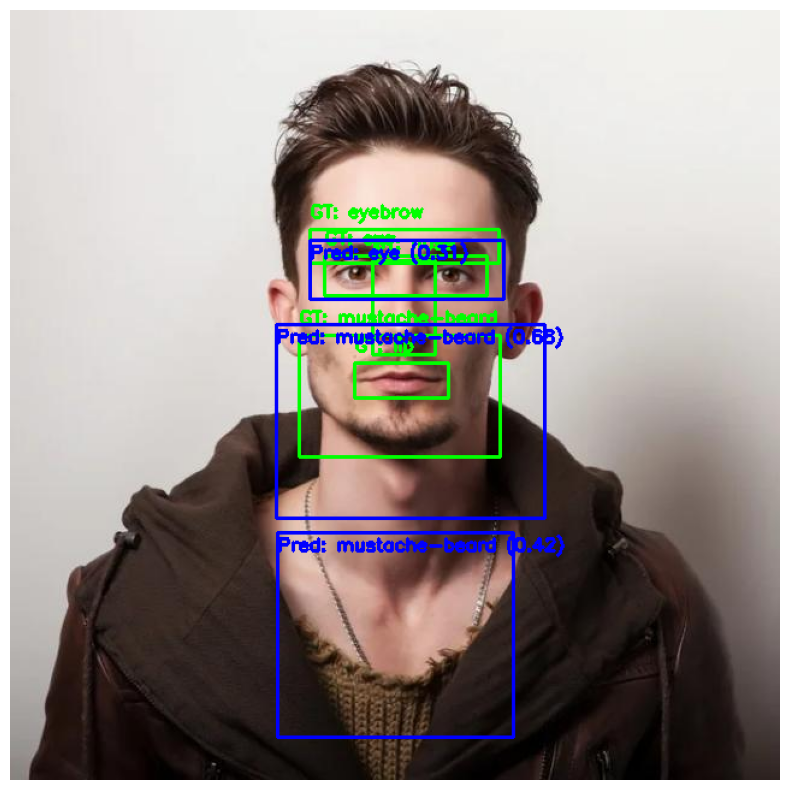

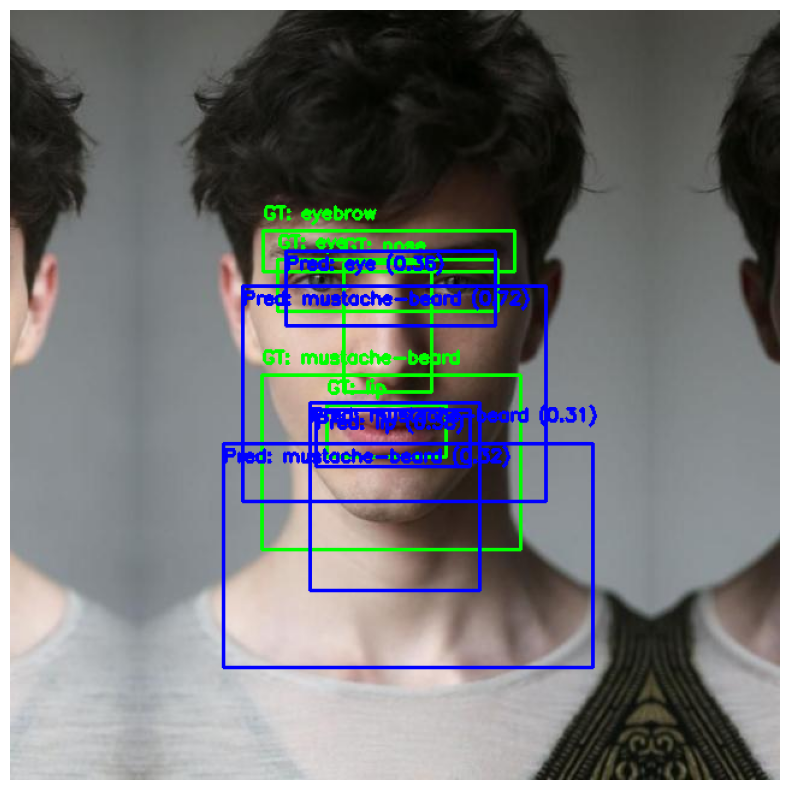

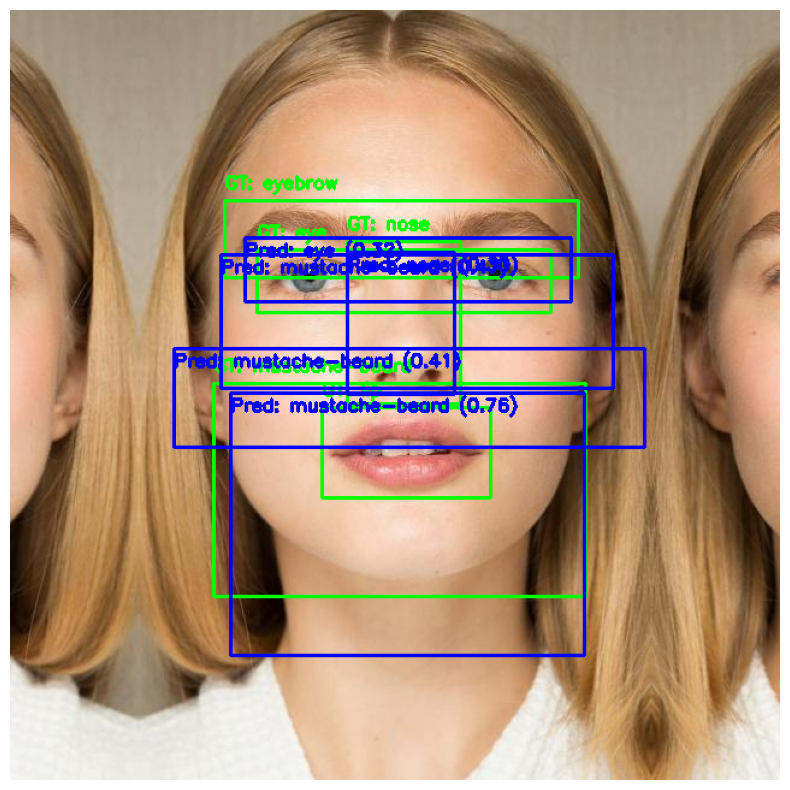

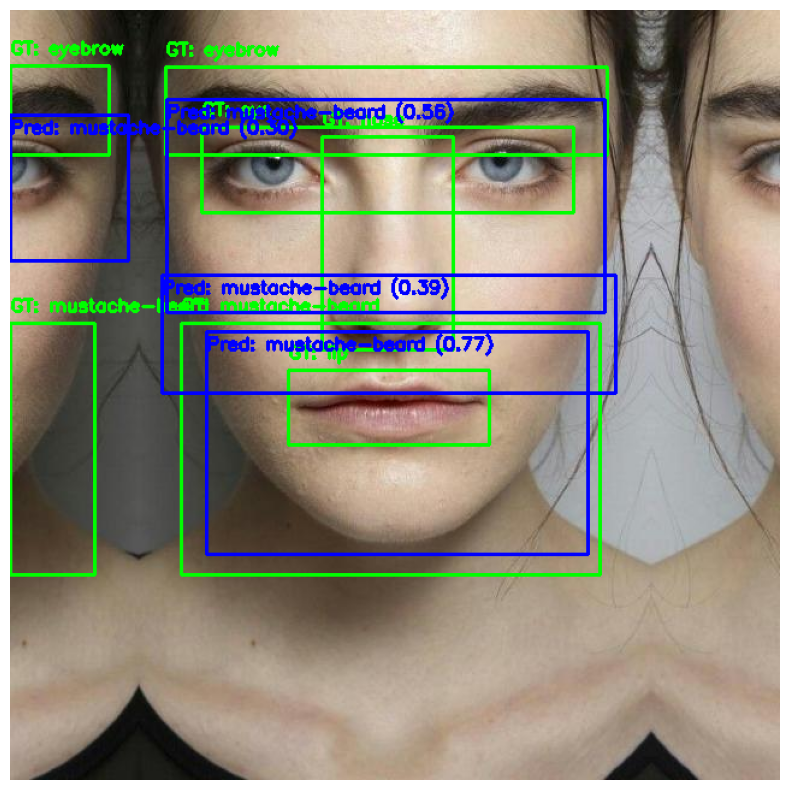

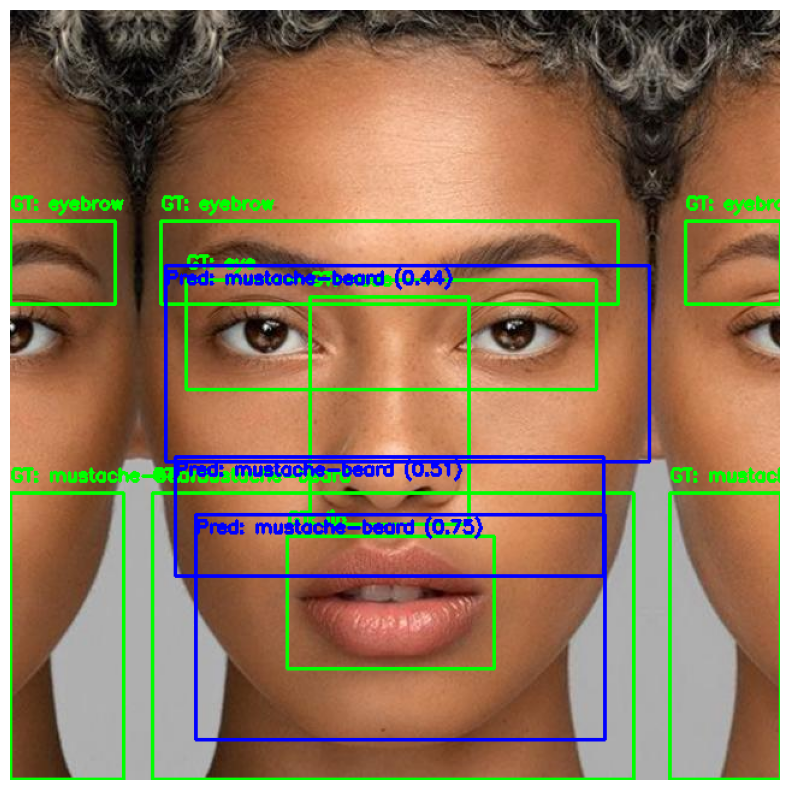

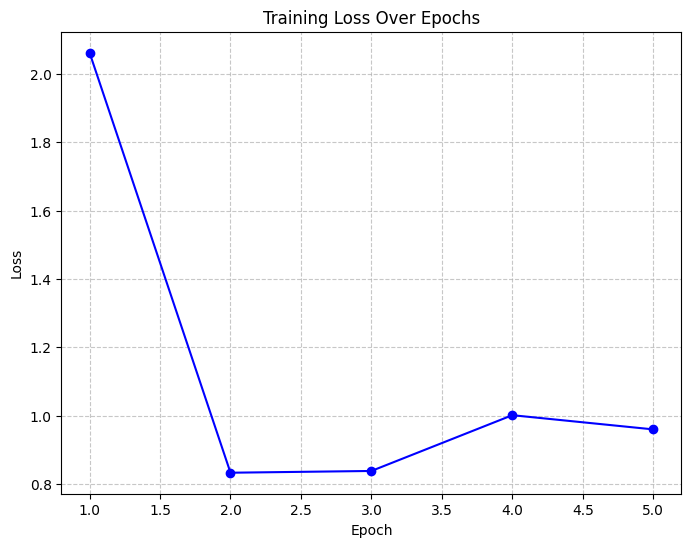

In [32]:
class_metrics = evaluate_model(model, TEST_IMAGES_PATH, TEST_LABELS_PATH)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), losses_list, marker='o', linestyle='-', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [55]:
import os
import numpy as np
import glob
import torch
from PIL import Image
from torchvision import transforms

# Load the trained Faster R-CNN model
model_path = "/content/drive/My Drive/ColabNotebooks/Facial Feature Extraction Dataset/faster_rcnn_facial.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 6  # Background + Face
# Get the input features for classifier and bbox regressor
in_features = model.roi_heads.box_predictor.cls_score.in_features
bbox_features = model.roi_heads.box_predictor.bbox_pred.in_features

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Replace the existing predictor with a correct one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


# Load model checkpoint
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model.to(device)
model.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])



def yolo_to_bbox(label, img_width, img_height):
    """Converts YOLO format (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)"""
    cls, x_c, y_c, w, h = map(float, label)
    x_min = (x_c - w / 2) * img_width
    y_min = (y_c - h / 2) * img_height
    x_max = (x_c + w / 2) * img_width
    y_max = (y_c + h / 2) * img_height
    return [x_min, y_min, x_max, y_max]


# Define IoU calculation
def compute_iou(box1, box2):
    """Computes IoU between two bounding boxes."""
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Compute intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Compute areas
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area != 0 else 0


# Load test images
test_images = glob.glob(os.path.join(TEST_IMAGES_PATH, "*.jpg"))

# Initialize evaluation metrics
iou_threshold = 0.5
all_iou, tp, fp, fn = [], 0, 0, 0

for img_path in test_images:
    #print("image path", img_path)
    img_name = os.path.basename(img_path).replace(".jpg", ".txt")
    label_path = os.path.join(TEST_LABELS_PATH, img_name)
    #print("image path", label_path)

    if not os.path.exists(label_path):
        print(f"Missing label for {img_name}")
    gt_boxes = []

    with open(label_path, "r") as f:
        lines = f.readlines()
        #print("Sample label content:", lines)
        gt_boxes = [line.strip().split() for line in lines]

    #print("Parsed Ground Truth Boxes:", gt_boxes)
    import numpy as np


    # Example: Convert all ground truth boxes
    img_width, img_height = 640, 640  # Replace with actual image size

    gt_boxes = [yolo_to_bbox(box, img_width, img_height) for box in gt_boxes]
    #print("Converted Ground Truth Boxes:", gt_boxes)

    # Load and preprocess image
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        predictions = model([img_tensor])

    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()

    # Filter predictions with confidence > 0.5
    pred_boxes = pred_boxes[pred_scores > 0.5]


    matched = set()
    for pb in pred_boxes:
        ious = [compute_iou( gb, pb) for gb in gt_boxes]
        # Compute IoU for each pair
        #print(f"IoU values for {img_name}: {ious}")
        if ious and max(ious) > iou_threshold:
            tp += 1
            matched.add(np.argmax(ious))
        else:
            fp += 1

    fn += len(gt_boxes) - len(matched)

    if len(gt_boxes) > 0 and len(pred_boxes) > 0:
        all_iou.extend(ious)

# Compute evaluation metrics
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
mean_iou = np.mean(all_iou) if all_iou else 0

# Print evaluation results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")

Precision: 0.3992
Recall: 0.2500
F1-Score: 0.3075
Mean IoU: 0.1124
